In [1]:
# import gymnasium as gym
# import os
# import matplotlib.pyplot as plt
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output

# env = gym.make("LunarLander-v2", render_mode="rgb_array")
# observation, info = env.reset(seed=42)
# for _ in range(1000):
#     action = env.action_space.sample()  # this is where you would insert your policy
#     observation, reward, terminated, truncated, info = env.step(action)

#     if terminated or truncated:
#         observation, info = env.reset()
#     clear_output(wait=True)
#     plt.imshow( env.render() )
#     plt.show()
# env.close()

In [2]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
import collections # For dequeue for the memory buffer


class MemoryBuffer(object):
    def __init__(self, max_size):
        self.memory_size = max_size
        self.trans_counter=0 # num of transitions in the memory
                             # this count is required to delay learning
                             # until the buffer is sensibly full
        self.index=0         # current pointer in the buffer
        self.states = np.zeros((self.memory_size, 8))       # list of states
        self.new_states = np.zeros((self.memory_size, 8))   # list of new states
        self.actions = np.zeros(self.memory_size, dtype=np.int8)  # list of actions (integer)
        self.actions_oh = np.zeros((self.memory_size, 4), dtype=np.int8)  # list of one hot encoded actions
        self.rewards = np.zeros(self.memory_size)  # list of rewards
        self.terminals = np.zeros(self.memory_size, dtype=np.int8) # list of end of game signals
    
    def action_to_oh(self, action):
        """ Get one hot representation of an action """
        
        arr = np.zeros(4)
        arr[action] = 1.0
        return arr
    
    def ix(self):
        """ Get current buffer index"""
        return self.trans_counter % self.memory_size
        
    
    def save(self, state, action, reward, new_state, done):
        # print("Store transition, action=", action)
        self.states[self.ix()] = state
        self.new_states[self.ix()] = new_state
        self.rewards[self.ix()] = reward
        self.terminals[self.ix()] = 1-int(done)
        self.actions[self.ix()] = action
        self.actions_oh[self.ix()] = self.action_to_oh(action)
        # print("Stored", self.action[self.ix()])
        self.trans_counter += 1

    def random_sample(self, batch_size):
        assert self.trans_counter >= batch_size # start sampling when sufficiently full
        choose_from = min(self.trans_counter, self.memory_size)
        indices = np.random.choice(choose_from, batch_size) # number of transitions to sample
        return self.states[indices], self.actions[indices], self.actions_oh[indices], \
               self.rewards[indices],self.new_states[indices], self.terminals[indices]
    
class SingleQAgent(object):
    def __init__(self, lr, gamma, epsilon, batch_size,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000):
        self.gamma = gamma # alpha = learn rate, gamma = discount
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec # decrement of epsilon for larger spaces
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.memory = MemoryBuffer(mem_size)
        nn = Sequential([
                    Dense(256, input_shape=(8,)),
                    Activation('relu'),
                    Dense(256),
                    Activation('relu'),
                    Dense(4)])
        nn.compile(optimizer=Adam(lr=lr), loss='mse')
        self.q_func = nn

    def save(self, state, action, reward, new_state, done):
        self.memory.save(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon: 
            # exploring: return a random action
            return np.random.choice([i for i in range(4)])
        else:
            # greedy, returning best known action
            sa = self.q_func.predict(state, verbose=0)
            return np.argmax(sa)

    def reduce_epsilon(self):
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                       self.epsilon_min else self.epsilon_min
        
        
    def learn(self):
        if self.memory.trans_counter < self.batch_size: # wait before you start learning
            return
            
        # 1. Choose a sample from past transitions:
        states, actions, actions_oh, \
        rewards, new_states, terminals = self.memory.random_sample(self.batch_size)
        
        # 2. Compute predicted q value for the sample states
        q = self.q_func.predict(states, verbose=0)
        
        # 3. Compute (using the same Q network) q value for the new states
        q_next = self.q_func.predict(new_states, verbose=0)
        
        # 4. Improve the Q network
        inx = np.arange(self.batch_size, dtype=np.int32)
        q[inx, actions] = rewards + self.gamma*np.max(q_next, axis=1)*terminals
        self.q_func.fit(states, q, verbose=0)
        
        # 5. Reduce the exploration rate
        self.reduce_epsilon()

    def save_model(self, path):
        self.q_func.save(path)

    def load_saved_model(self, path):
        self.q_func = load_model(path)
        
class DoubleQAgent(object):
    def __init__(self, lr, gamma, epsilon, batch_size,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, replace_q_target = 100):
        self.gamma = gamma # alpha = learn rate, gamma = discount
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec # decrement of epsilon for larger spaces
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.memory = MemoryBuffer(mem_size)
        self.replace_q_target = replace_q_target
        nn = Sequential([
                    Dense(128, input_shape=(8,)),
                    Activation('relu'),
                    Dense(128, input_shape=(8,)),
                    Activation('relu'),
                    Dense(128),
                    Activation('relu'),
                    Dense(4)])
        nn.compile(optimizer=Adam(lr=lr), loss='mse')
        self.q_func = nn
        
        nnt = Sequential([
                    Dense(128, input_shape=(8,)),
                    Activation('relu'),
                    Dense(128, input_shape=(8,)),
                    Activation('relu'),
                    Dense(128),
                    Activation('relu'),
                    Dense(4)])
        nnt.compile(optimizer=Adam(lr=lr), loss='mse')
        self.q_func_target = nnt

    def save(self, state, action, reward, new_state, done):
        self.memory.save(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon: 
            # exploring: return a random action
            return np.random.choice([i for i in range(4)])
        else:
            # greedy, returning best known action
            sa = self.q_func.predict(state, verbose=0)
            return np.argmax(sa)

    def reduce_epsilon(self):
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                       self.epsilon_min else self.epsilon_min
        
        
    def learn(self):
        if self.memory.trans_counter < self.batch_size: # wait before you start learning
            return
            
        # 1. Choose a sample from past transitions:
        states, actions, actions_oh, \
        rewards, new_states, terminals = self.memory.random_sample(self.batch_size)
        
        # 2. Compute predicted q value for the sample states
        q = self.q_func.predict(states, verbose=0)
        
        # 3. Compute (using the same Q network) q value for the new states
        q_next = self.q_func.predict(new_states, verbose=0)
        
        # 4. Update the Q target using the second Q network
        q_target = self.q_func_target.predict(new_states, verbose=0)
        
        # 4. Improve the Q network
        inx = np.arange(self.batch_size, dtype=np.int32)
        q[inx, actions] = rewards + self.gamma*q_target[inx, np.argmax(q_next, axis=1).astype(int)]*terminals
        self.q_func.fit(states, q, verbose=0)
        
        # 5. Reduce the exploration rate
        self.reduce_epsilon()
        
        if self.memory.trans_counter % self.replace_q_target == 0: # wait before you start learning
            self.q_func_target.set_weights(self.q_func.get_weights())

    def save_model(self, path):
        self.q_func.save(path)

    def load_saved_model(self, path):
        self.q_func = load_model(path)
        if self.epsilon == 0.0:
            self.q_func_target.set_weights(self.q_func.get_weights())
    
    

2023-02-05 16:48:58.322749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [24]:
# import tensorflow.compat.v1 as tf
# from tensorflow.keras import Model, Sequential
# from tensorflow.keras.layers import Dense, Embedding, Reshape
# from tensorflow.keras.optimizers import Adam

# import numpy as np
# import matplotlib.pyplot as plt
# import random
# from collections import deque
# import time
# # tf.disable_v2_behavior() # testing on tensorflow 1

In [25]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [ ]:
import gymnasium as gym
import os
import matplotlib.pyplot as plt
import json # for dumping debug data
import time # for benchmarking 

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output
LEARN_EVERY = 4
def train_agent(atype='double', n_episodes=100, load_latest_model=False):
    env = gym.make("LunarLander-v2")
    n_games = 2000
    if atype == 'double':
        agent = DoubleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.99996, lr=0.0005, mem_size=1000000, batch_size=64, epsilon_end=0.01)
    elif atype == 'single':
        agent = SingleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.99996, lr=0.0005, mem_size=1000000, batch_size=64, epsilon_end=0.01)
    
    if load_latest_model:
        agent.load_saved_model('{}_dqn_model.h5'.format(atype))
        print('Loaded most recent {} model.'.format(atype))
        
    scores = []
    eps_history = []
    for i in range(n_games):
        terminated = False
        truncated = False
        score = 0
        state = env.reset()[0]
        steps = 0
        while not (terminated or truncated):
            action = agent.choose_action(state)
            #print(action)
            new_state, reward, terminated, truncated, info = env.step(action)
            if truncated:
                print("Truncated game at {}", steps)
            score += reward
            agent.save(state, action, reward, new_state, terminated or truncated)
            state = new_state
            if steps > 0 and steps % LEARN_EVERY == 0:
                agent.learn()
            if steps>0 and steps % 1000 == 0:
                print("Steps", steps)
            steps += 1
        eps_history.append(agent.epsilon)

        scores.append(score)

        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model('{}_dqn_model.h5'.format(atype))
            with open("{}_dqn_scores_{}.json".format(atype, int(time.time())), "w") as fp:
                json.dump(scores, fp)
            with open("{}_eps_history_{}.json".format(atype, int(time.time())), "w") as fp:
                json.dump(eps_history, fp)

        filename = 'lunarlander.png'

    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)
    
train_agent(atype='double', n_episodes=100, load_latest_model=False)

episode:  0 score: -114.03  average score -114.03
episode:  1 score: -165.54  average score -139.79
episode:  2 score: -82.46  average score -120.68
episode:  3 score: -108.29  average score -117.58
episode:  4 score: -97.98  average score -113.66
episode:  5 score: -298.06  average score -144.39
episode:  6 score: -120.89  average score -141.04
episode:  7 score: -75.55  average score -132.85
episode:  8 score: -87.06  average score -127.76
episode:  9 score: -214.97  average score -136.48
episode:  10 score: -119.33  average score -134.92
episode:  11 score: -186.78  average score -139.25
episode:  12 score: -165.01  average score -141.23
episode:  13 score: -301.88  average score -152.70
episode:  14 score: -243.04  average score -158.73
episode:  15 score: -87.50  average score -154.27
episode:  16 score: -285.54  average score -161.99
episode:  17 score: -355.82  average score -172.76
episode:  18 score: -262.43  average score -177.48
episode:  19 score: -165.83  average score -17

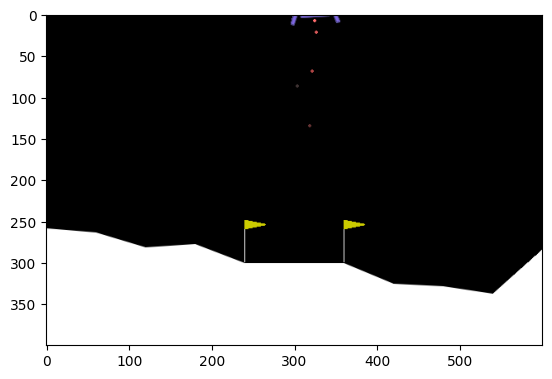

In [ ]:
# Visualize the model
import gymnasium as gym
import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

def visualize_model(name, atype='single'):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = SingleQAgent(gamma=0.99, epsilon=0.0, lr=0.0005, mem_size=1000000, batch_size=64, epsilon_end=0.01)
    agent.load_saved_model(name)
    state, info = env.reset(seed=42)
    for _ in range(5):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            if truncated:
                print("Truncated game at {}", steps)
            state = new_state
            clear_output(wait=True)
            plt.imshow( env.render() )
            plt.show()
        state = env.reset()[0]
    env.close()

visualize_model('double_dqn_model_epoch_50_fc256xfc256.h5', atype='double')